In [1]:
import numpy as np
import pandas as pd
#import lightgbm as lgb
import xgboost as xgb

from sklearn import  model_selection, linear_model
from sklearn.metrics import mean_squared_log_error, recall_score
from sklearn.model_selection import cross_validate
from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.neighbors import KNeighborsRegressor
from matplotlib import pyplot

import os
import matplotlib.pyplot as plt

In [2]:
data_dir = './data/'

## Utils

In [3]:
def rmsle(est, x, y_test):
    """
    Метрика rmsle

    :est: обученный экземпляр модели
    :x: объекты на которых нужно предсказать значение
    :y_test: фактическое значение объектов
    :returns: значение метрики rmsle на выборке x
    """

    predict = est.predict(x)
    predict = [x if x > 0 else 0 for x in predict]
    return np.sqrt(mean_squared_log_error(y_test, predict ))


def regr_score(x_train, y_train, regr, scoring):
    """
    Расчет кроссвалидации и вывод на экран

    :x_train: обучающая выборка
    :y_train: целевое значение
    :regr: экземпляр модели
    :scoring: метрика
    """
    scores = cross_validate(regr, 
                            x_train, 
                            y_train, 
                            scoring=scoring,
                            cv=5, 
                            return_train_score=False)
    
    scores_list = scores[list(scores.keys())[-1]]
    print(scores_list)
    print(f'mean score -- {np.mean(scores_list)}')
    
    
def get_data():
    df_x = pd.read_csv(f'{data_dir}/train.csv')
    df_x = df_x.fillna(-1)
        
    y = df_x['label']
    df_x = df_x.drop(['label', 'status', 'short', 'activity_title', 'title_activity_type',
                      'activity_description', 'title_direction', 'comment_direction'], 
                     axis=1)
    return df_x, y

## Read data

In [4]:
df_x, y = get_data()
print(df_x.shape)
print(len(y))
print(df_x.columns)

(13000, 11)
13000
Index(['id_bet', 'run_id', 'user_id', 'direction_id', 'activity_id',
       'size_max', 'size_min', 'is_educational', 'is_checkin_required',
       'activity_type_id', 'main_competence_id'],
      dtype='object')


In [5]:
x_train = np.array(df_x)
y_train = np.array(y)

In [6]:
# Посмотрим, какие есть файлы и положим их в словарь
dfs = {}
for i, x in enumerate(os.listdir(data_dir)):
    file_name = x.split('.')[0]
    print(f'{i} -- {file_name}')
    dfs[file_name] = pd.read_csv(f'{data_dir}/{x}')

0 -- user_role
1 -- competence
2 -- author
3 -- time_slot
4 -- test
5 -- competence_level
6 -- competence_type
7 -- activity_track
8 -- track
9 -- activity_tag
10 -- role
11 -- train
12 -- place
13 -- activity_author
14 -- event
15 -- user_tag
16 -- sample_submission


## Simple prediction
Для начала нужно попробовать самые простые модели, чтобы примерно понимать, какое качество ожидать

In [7]:
# Наивная модель, где предсказанием является среднее значение, полученное на обучающей выборке
regr = DummyRegressor(strategy='mean')
regr_score(x_train, y_train, regr, rmsle)
print()

# Наивная модель, где предсказанием является медиана, полученная на обучающей выборке
# Эта статистика менее подвержена выбросам, поэтому, возможно, даст лучшее качество
regr = DummyRegressor(strategy='median')
regr_score(x_train, y_train, regr, rmsle)
print()

# Градиентный бустинг
regr = xgb.XGBRegressor()
#regr = lgb.LGBMRegressor()
regr_score(x_train, y_train, regr, rmsle)
print()

# К средних соседей
regr = KNeighborsRegressor()
regr_score(x_train, y_train, regr, rmsle)

[3.17623168 2.64802335 1.97579148 1.95395719 1.93442136]
mean score -- 2.337685013625203

[2.28039206 1.64154422 1.45836226 1.9740166  2.50493593]
mean score -- 1.97185021481104

[1.78002104 2.23344153 1.55746428 1.83276392 2.26488835]
mean score -- 1.9337158235699925

[1.27742155 1.6914369  1.57470835 1.92055414 1.92987721]
mean score -- 1.6787996311871414


In [8]:
regr = xgb.XGBRegressor(n_estimators=68)
regr_score(x_train, y_train, regr, rmsle)
print()

regr = KNeighborsRegressor(n_neighbors=4, weights='distance',  p=1)
regr_score(x_train, y_train, regr, rmsle)

[1.73313123 1.50553292 1.55535309 1.83568245 2.2077006 ]
mean score -- 1.767480059031603

[1.34620249 1.6663659  1.57248305 1.8823089  1.86615139]
mean score -- 1.6667023453319534


## Drop outliers
Качество улучшилось, но не сильно. Возможно, нужно что то еще придумать.

Можно посмотреть на наш таргет

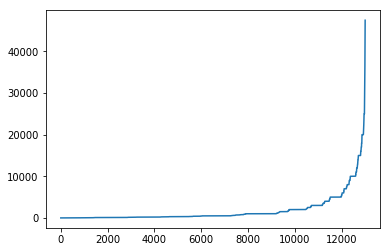

In [9]:
pd.Series(sorted(y_train)).plot()

Видно, что есть выбросы и, возможно, они мешают алгоритму уловить настоящую закономерность, поэтому можно ему помочь, удалив выбросы.

Делать это можно несколькими способами, но возьмем самый простой, просто выкинем все значения которые больше 95 перцентиля. Кстати, это значение тоже можно подбирать как гиперпараметр.

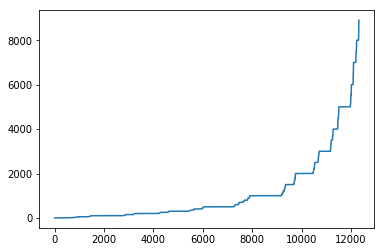

In [10]:
pd.Series(sorted([x for x in y_train if x < np.quantile(y_train, 0.95)])).plot()

Выглядит уже лучше, ставки на 10000 - 40000 уже не участвуют в обучении.

In [11]:
# Формирование новой выборки без выбросов
x_train = np.array(df_x)
y_train = np.array(y)

x_train = x_train[[True if x < np.quantile(y_train, 0.95) else False for x in y_train]]
y_train = [x for x in y_train if x < np.quantile(y_train, 0.95)]

По аналогии с тем как делали выше, посмотрим качество моделей

In [13]:
# Наивная модель где предсказанием является среднее значение полученное на обучающей выборке
regr = DummyRegressor(strategy='mean')
regr_score(x_train, y_train, regr, rmsle)
print()

# Наивная модель где предсказанием является медиана полученная на обучающей выборке
# Эта статистика менее подвержена выбросам, поэтому возможно даст лучшее качество
regr = DummyRegressor(strategy='median')
regr_score(x_train, y_train, regr, rmsle)
print()

# Градиентный бустинг 
regr = xgb.XGBRegressor()
regr_score(x_train, y_train, regr, rmsle)
print()

# К средних соседей
regr = KNeighborsRegressor()
regr_score(x_train, y_train, regr, rmsle)

[2.71190343 2.31330984 1.60983129 1.75684083 1.77779191]
mean score -- 2.033935461952158

[1.98036921 1.62175819 1.47492428 1.8099698  2.18064734]
mean score -- 1.8135337643858425

[1.4675376  2.30300629 1.44157375 1.69373776 1.90377605]
mean score -- 1.7619262915365634

[1.31851903 1.4221127  1.60173555 1.82461886 1.85278949]
mean score -- 1.6039551248369093


In [15]:
regr = xgb.XGBRegressor(n_estimators=66, num_leaves=38)
regr_score(x_train, y_train, regr, rmsle)
print()

regr = KNeighborsRegressor(n_neighbors=4, weights='distance',  p=1)
regr_score(x_train, y_train, regr, rmsle)

[1.49982017 1.61136678 1.44575125 1.70008643 1.87011865]
mean score -- 1.6254286556070003

[1.33479472 1.46249063 1.58680068 1.80824223 1.82684265]
mean score -- 1.6038341807566585


## Merge
Добавим данные

In [18]:
x_train = np.array(df_x)
y_train = np.array(y)

# тут происходит мерж исходных данных и дополнительных, которые мы считали в словарь dfs

df_tmp = pd.merge(df_x, dfs['activity_author'].groupby('activity_id').count().reset_index(),  
                  how='left', 
                  left_on='activity_id', right_on='activity_id', 
                  suffixes=('_x', 'activity_author'))

df_tmp = pd.merge(df_tmp, dfs['event'].groupby('run_id').count().reset_index(),  
                  how='left', 
                  left_on='run_id', right_on='run_id', 
                  suffixes=('_x', '_event'))

df_tmp = pd.merge(df_tmp, dfs['user_role'].drop_duplicates('user_id'),
                  how='left', 
                  left_on='user_id', right_on='user_id', 
                  suffixes=('_x', '_event'))

In [19]:
regr = xgb.XGBRegressor()
regr_score(df_tmp, y_train, regr, rmsle)
print()


regr = KNeighborsRegressor(n_neighbors=4, weights='distance',  p=1)
regr_score(x_train, y_train, regr, rmsle)

[1.77679928 1.66666112 1.54781792 1.82930091 2.29371744]
mean score -- 1.8228593360937573

[1.34620249 1.6663659  1.57248305 1.8823089  1.86615139]
mean score -- 1.6667023453319534


In [20]:
print(df_tmp.shape)
print(len(y))

df_tmp = df_tmp.fillna(-1)
x_train = np.array(df_tmp)
y_train = np.array(y)

x_train = x_train[[True if x < np.quantile(y_train, 0.95) else False for x in y_train]]
y_train = [x for x in y_train if x < np.quantile(y_train, 0.95)]

print(x_train.shape)
print(len(y_train))

(13000, 16)
13000
(12320, 16)
12320


In [22]:
regr = xgb.XGBRegressor(n_estimators=60, num_leaves=39)
regr_score(x_train, y_train, regr, rmsle)
print()


regr = KNeighborsRegressor(n_neighbors=4, weights='distance',  p=1)
regr_score(x_train, y_train, regr, rmsle)

[1.4931163  1.57650017 1.42860204 1.69665509 1.85644485]
mean score -- 1.6102636900048561

[1.33649867 1.46744419 1.58286911 1.80620596 1.8251924 ]
mean score -- 1.6036420644012694


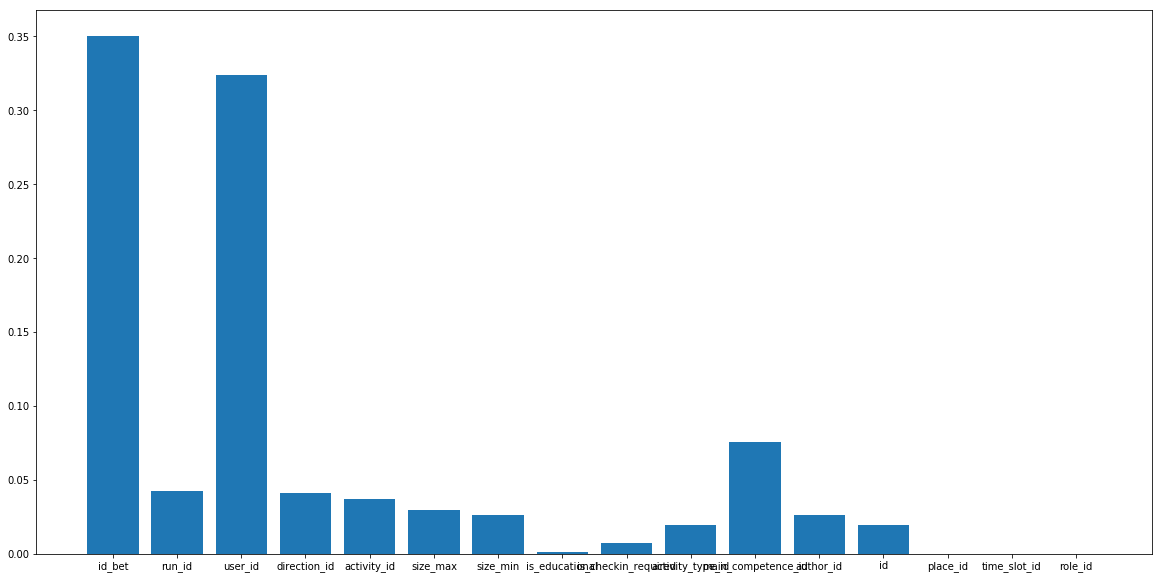

In [23]:
regr = xgb.XGBRegressor()
regr.fit(x_train, y_train)
pyplot.figure(figsize=(20,10))
pyplot.bar(df_tmp.columns, regr.feature_importances_)
pyplot.show()

Самыми важными признакми являются user_id и id_bet

Можно попробовать посмотреть то же самое, заэнкодив признаки

## Predict

Сделаем сабмит

In [25]:
df_tmp = pd.merge(df_x, dfs['activity_author'].groupby('activity_id').count().reset_index(),  
                  how='left', 
                  left_on='activity_id', right_on='activity_id', 
                  suffixes=('_x', 'activity_author'))

df_tmp = pd.merge(df_tmp, dfs['event'].groupby('run_id').count().reset_index(),  
                  how='left', 
                  left_on='run_id', right_on='run_id', 
                  suffixes=('_x', '_event'))

df_tmp = pd.merge(df_tmp, dfs['user_role'].drop_duplicates('user_id'),
                  how='left', 
                  left_on='user_id', right_on='user_id', 
                  suffixes=('_x', '_event'))

In [26]:
df_x_test = pd.read_csv(f'{data_dir}/test.csv')
df_x_test = df_x_test.fillna(-1)
df_x_test = df_x_test.drop(['short', 'activity_title', 'title_activity_type',
            'activity_description', 'title_direction', 'comment_direction'], axis=1)

In [27]:
df_test = pd.merge(df_x_test, dfs['activity_author'].groupby('activity_id').count().reset_index(),  
                  how='left', 
                  left_on='activity_id', right_on='activity_id', 
                  suffixes=('_x', 'activity_author'))

df_test = pd.merge(df_test, dfs['event'].groupby('run_id').count().reset_index(),  
                  how='left', 
                  left_on='run_id', right_on='run_id', 
                  suffixes=('_x', '_event'))

df_test = pd.merge(df_test, dfs['user_role'].drop_duplicates('user_id'),
                  how='left', 
                  left_on='user_id', right_on='user_id', 
                  suffixes=('_x', '_event'))

print(df_tmp.columns.values)
print(df_test.columns.values)

['id_bet' 'run_id' 'user_id' 'direction_id' 'activity_id' 'size_max'
 'size_min' 'is_educational' 'is_checkin_required' 'activity_type_id'
 'main_competence_id' 'author_id' 'id' 'place_id' 'time_slot_id' 'role_id']
['id_bet' 'run_id' 'user_id' 'direction_id' 'activity_id' 'size_max'
 'size_min' 'is_educational' 'is_checkin_required' 'activity_type_id'
 'main_competence_id' 'author_id' 'id' 'place_id' 'time_slot_id' 'role_id']


In [28]:
df_tmp = df_tmp.fillna(-1)
df_test = df_test.fillna(-1)


x_train = np.array(df_tmp)
x_test = np.array(df_test)
y_train = np.array(y)

In [29]:
df_tmp = df_tmp.fillna(-1)
x_train = np.array(df_tmp)

y_train = np.array(y)

x_train = x_train[[True if x < np.quantile(y_train, 0.95) else False for x in y_train]]
y_train = [x for x in y_train if x < np.quantile(y_train, 0.95)]

df_test = df_test.fillna(-1)
x_test = np.array(df_test)

In [30]:
regr = xgb.XGBRegressor(n_estimators=68)
regr.fit(x_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=68,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [31]:
%%time
test_pred = regr.predict(x_test)

CPU times: user 6.41 ms, sys: 1.67 ms, total: 8.08 ms
Wall time: 6.05 ms


In [32]:
submit = pd.concat([df_test['id_bet'], pd.Series(test_pred)], axis=1)
submit.columns=['id_bet', 'label']
submit.to_csv('submit_baseline.csv', index=False)